# LDC Implementation in Python/JAX
Written By: Sungje Park

In [2]:
import jax
from jax import numpy as jnp

import sys
sys.path.append('..')
from src.environment import *
from src.elements import *
from src.dynamics import *
from utils.test_utils import *
from src.methods import *
from tqdm import tqdm
import matplotlib.pyplot as plt

Defining Vars.

In [ ]:
rho_ref = 1 # reference density
Mu = .1 # kinematic Viscosity
Re = 100 # reynolds number
N_x = 100 # number of cells in the x dir
N_y = N_x # number of cells in the y dir
dx = 1 # spacing in x
dy = 1 # spacing in y
U_lid = Re*Mu/N_x # velocity of lid
Tau = 3*Mu+.5
dt = .1

In [4]:
cell_mesh = jnp.reshape(jnp.asarray(range(N_x*N_y)),(N_y,N_x))
node_mesh = jnp.reshape(jnp.asarray(range((N_x+1)*(N_y+1))),(N_y+1,N_x+1))
face_mesh = jnp.asarray(range(N_x*(N_y+1)+(N_x+1)*N_y))
vert_mesh = jnp.reshape(face_mesh[0:N_x*(N_y+1)],(N_y,N_x+1))
horz_mesh = jnp.reshape(face_mesh[N_x*(N_y+1):],(N_y+1,N_x))

In [5]:
dynamics = D2Q9(tau=Tau,delta_t = dt)
Element.dynamics = dynamics
Environment.dynamics = dynamics

In [6]:
def create_cell(cell_ind):
    loc = jnp.argwhere(cell_mesh == cell_ind)[0]
    x = loc[1]
    y = loc[0]
    pdf = dynamics.ones_pdf()
    face_ind = jnp.asarray([vert_mesh[y,x],
                            horz_mesh[y,x],
                            vert_mesh[y,x+1],
                            horz_mesh[y+1,x]])
    face_n = jnp.asarray([-1,-1,1,1])
    return Cell.pdf_init(pdf,face_ind,face_n)

cells = [create_cell(ind) for ind in tqdm(range(N_x*N_y))]

100%|██████████| 100/100 [00:01<00:00, 53.79it/s]


In [7]:
def create_node(node_ind):
    loc = jnp.argwhere(node_mesh==node_ind)[0]
    x = loc[1]
    y = loc[0]
    pdf = dynamics.ones_pdf()
    cell_index = []
    cell_dists = []
    cell_dist = jnp.sqrt(2)
    def cell_append(tl,tr,bl,br):
        if tl:
            cell_index.append(cell_mesh[y-1,x-1]) # top left
            cell_dists.append(cell_dist)
        if tr:
            cell_index.append(cell_mesh[y-1,x]) # top right
            cell_dists.append(cell_dist)

        if br:
            cell_index.append(cell_mesh[y,x]) # bottom right
            cell_dists.append(cell_dist)

        if bl:
            cell_index.append(cell_mesh[y,x-1])# bottom left
            cell_dists.append(cell_dist)

    if y == 0:
        type = 1
        vel = jnp.asarray([U_lid,0])
        if x!=0 and x!=N_x:
            cell_append(False,False,True,True)
        elif x==0:
            vel = jnp.asarray([0,0])
            cell_append(False,False,False,True)
        elif x==N_x:
            vel = jnp.asarray([0,0])
            cell_append(False,False,True,False)

    elif y == N_y:
        type = 1
        vel = jnp.asarray([0,0])
        if x!=0 and x!=N_x:
            cell_append(True,True,False,False)
        elif x==0:
            cell_append(False,True,False,False)
        elif x==N_x:
            cell_append(True,False,False,False)

    elif x == 0:
        type = 1
        vel = jnp.asarray([0,0])
        # since all corner cases handled
        cell_append(False,True,False,True)

    elif x == N_x:
        type = 1
        vel = jnp.asarray([0,0])
        cell_append(True,False,True,False)
    else:
        type = 0
        cell_append(True,True,True,True)

    node = Node.pdf_init(pdf,jnp.asarray(type),jnp.asarray(cell_index),jnp.asarray(cell_dists))

    if type == 1:
        node.vel = vel
    return node
nodes = [create_node(ind) for ind in tqdm(range((N_x+1)*(N_y+1)))]

100%|██████████| 121/121 [00:02<00:00, 58.40it/s]


In [8]:
def create_face(face_ind):
    pdf = dynamics.ones_pdf()
    nodes_ind = []
    stencil_ind = []
    stencil_dists = jnp.asarray([.5,.5])
    
    if face_ind < N_x*(N_y+1): # vertical faces
        loc = jnp.argwhere(vert_mesh==face_ind)[0]
        x = loc[1]
        y = loc[0]
        nodes_ind.append(jnp.asarray([nodes[node_mesh[y,x]].type,node_mesh[y,x]]))
        nodes_ind.append(jnp.asarray([nodes[node_mesh[y+1,x]].type,node_mesh[y+1,x]]))

        if x == 0:
            stencil_ind.append(-1)
            stencil_ind.append(cell_mesh[y,x])
        elif x == N_x:
            stencil_ind.append(cell_mesh[y,x-1])
            stencil_ind.append(-1)
        else:
            stencil_ind.append(cell_mesh[y,x-1])
            stencil_ind.append(cell_mesh[y,x])

        n = jnp.asarray([1,0])
    else: # horizontal faces
        loc = jnp.argwhere(horz_mesh==face_ind)[0]
        x = loc[1]
        y = loc[0]
        nodes_ind.append(jnp.asarray([nodes[node_mesh[y,x]].type,node_mesh[y,x]]))
        nodes_ind.append(jnp.asarray([nodes[node_mesh[y,x+1]].type,node_mesh[y,x+1]]))

        if y == 0:
            stencil_ind.append(-1)
            stencil_ind.append(cell_mesh[y,x])
        elif y == N_y:
            stencil_ind.append(cell_mesh[y-1,x])
            stencil_ind.append(-1)
        else:
            stencil_ind.append(cell_mesh[y-1,x])
            stencil_ind.append(cell_mesh[y,x])

        n = jnp.asarray([0,1])

    face = Face.pdf_init(pdf,jnp.asarray(nodes_ind),jnp.asarray(stencil_ind),jnp.asarray(stencil_dists),n,jnp.asarray(1))
    return face

faces = [create_face(ind) for ind in tqdm(range((N_x)*(N_x+1)*2))]

100%|██████████| 220/220 [00:04<00:00, 53.04it/s]


In [9]:
env = Environment.create(cells,faces,nodes)
env.setMethods(Methods)
params,config = env.init()

In [10]:
params

{'cells': {'pdf': Array([[1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1.

In [11]:
for i in tqdm(range(10000)):
    params = env.step(params,config)

100%|██████████| 10000/10000 [00:00<00:00, 11801.26it/s]


In [12]:
params

{'cells': {'pdf': Array([[5.3191276 , 1.3256656 , 1.3444844 , 1.2311168 , 1.4225966 ,
          0.40224817, 0.25757617, 0.33461103, 0.3433921 ],
         [5.4679832 , 1.4487832 , 1.3620844 , 1.2078707 , 1.4557946 ,
          0.45418414, 0.23485313, 0.32969788, 0.3788392 ],
         [5.6215982 , 1.5578967 , 1.3953595 , 1.208001  , 1.4721447 ,
          0.48280457, 0.24028216, 0.32669136, 0.40126848],
         [5.747528  , 1.6463279 , 1.4236946 , 1.2172034 , 1.4826251 ,
          0.49977303, 0.24722686, 0.32525042, 0.4156121 ],
         [5.8563137 , 1.7145188 , 1.4477837 , 1.2355517 , 1.4909735 ,
          0.51130784, 0.25334895, 0.32559514, 0.42480892],
         [5.9606996 , 1.7651633 , 1.4699502 , 1.2652389 , 1.4990195 ,
          0.52096623, 0.2594086 , 0.32803664, 0.4304138 ],
         [6.0727944 , 1.8011434 , 1.4924607 , 1.3093668 , 1.5079576 ,
          0.5309201 , 0.26719403, 0.33311674, 0.43320873],
         [6.204802  , 1.8245022 , 1.5178732 , 1.37146   , 1.51887   ,
          0

In [13]:
vel = params["cells"]["vel"]

In [14]:
x = jnp.linspace(1/2/N_x,1-1/2/N_x,N_x)
y = jnp.linspace(1/2/N_y,1-1/2/N_y,N_y)
# x,y = jnp.meshgrid(x,y)
# x = x.flatten()
# y = y.flatten()

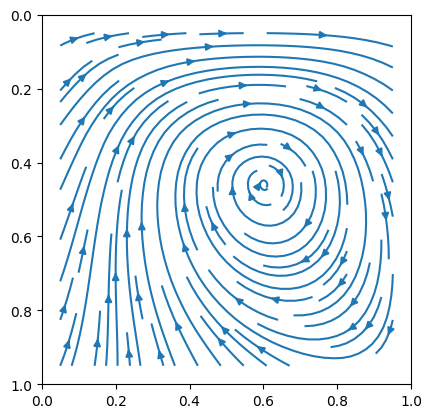

In [15]:
import numpy as np
x = np.asarray(x)
y = np.asarray(y)
u = np.asarray(vel[...,0].reshape(N_x,N_y))
v = np.asarray(vel[...,1].reshape(N_x,N_y))
plt.streamplot(x,y,u,v)
plt.axis("square")
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().invert_yaxis()
plt.show()

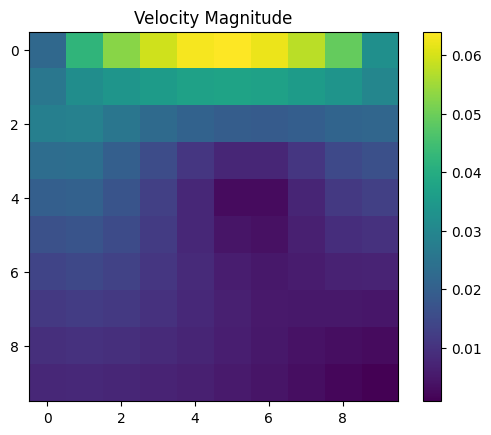

In [16]:
plt.imshow(jnp.sqrt(vel[...,0]**2+vel[...,1]**2).reshape(N_x,N_y))
plt.title("Velocity Magnitude")
plt.colorbar()
plt.show()

In [17]:
outx = jnp.mean(vel.reshape(N_x,N_y,2)[49:51,:,0],axis=0)
outy = jnp.mean(vel.reshape(N_x,N_y,2)[:,49:51,1],axis=1)

In [18]:
from scipy.io import loadmat
data = loadmat('../ref/ldc_Re100.mat')
refu = data['u'].T[...,jnp.newaxis]
refv = data['v'].T[...,jnp.newaxis]
refx = data['x'].squeeze()
refy = data['y'].squeeze()
# x,y = jnp.meshgrid(x,y)
# x = jnp.expand_dims(x.flatten(),axis=-1)
# y = jnp.expand_dims(y.flatten(),axis=-1)
# xy = jnp.concatenate((x,y),axis=-1)
sol = jnp.concatenate((refu,refv),axis=-1)

In [19]:
solx = sol[128,:,1]
soly = sol[:,128,0]

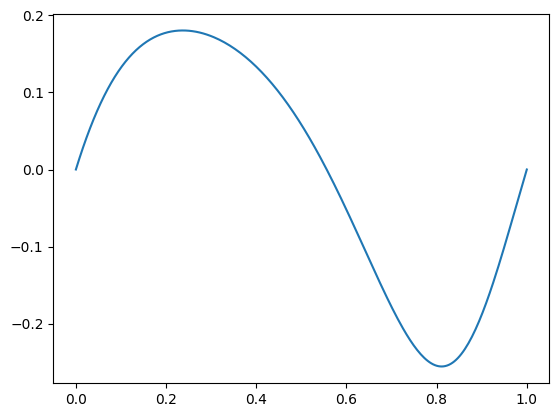

In [20]:
plt.plot(refy,solx)
plt.plot(x,-outx/U_lid)
plt.xlabel
plt.show()

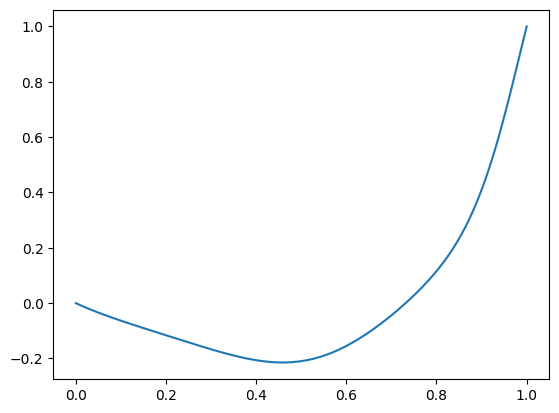

In [21]:
plt.plot(refy,soly)
plt.plot(np.flip(y),outy/U_lid)
plt.xlabel
plt.show()